In [2]:
import sys
sys.path.append('../')
from config_sing import *

In [89]:
import sqlite3
import itertools as it
from collections import defaultdict
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use("seaborn-whitegrid")

import random
from sklearn.manifold import TSNE
from functools import reduce

fun = np.core.defchararray.add
idx = np.arange(1,6).astype("str")

INPUT20X = reduce(fun, ["Input", idx,     "_20x"])
TFX_DMSO = reduce(fun, ["TFX",   idx[1:], "_DMSO"])
TFX_DEX  = reduce(fun, ["TFX",   idx[1:], "_Dex"])

SAMPLES  = np.concatenate([INPUT20X, TFX_DMSO, TFX_DEX])
SAMPLES

array(['Input1_20x', 'Input2_20x', 'Input3_20x', 'Input4_20x',
       'Input5_20x', 'TFX2_DMSO', 'TFX3_DMSO', 'TFX4_DMSO', 'TFX5_DMSO',
       'TFX2_Dex', 'TFX3_Dex', 'TFX4_Dex', 'TFX5_Dex'], dtype='<U30')

In [4]:
def gen_frag(sample):
    ### set query
    query_out = f"""
        SELECT c.fragment, f.start, f.end, f.pct_gc FROM Count c
        JOIN   Fragment f ON c.fragment = f.fragment
        WHERE  c.sample = '{sample}'
        """
    
    ### file path of database
    fdiry = os.path.join(FD_RES, 'database')
    fname = "fragment.db"
    fpath_db = os.path.join(fdiry, fname)

    ### query out fragments from the sample
    with sqlite3.connect(fpath_db) as conn:
        query  = query_out
        cursor = conn.cursor()
        rows   = cursor.execute(query)
        for row in rows:
            frag, start, end, pct_gc = row
            yield (frag, end-start, pct_gc)

In [5]:
def get_annot(frag):
    ### set query
    query_out = f"""
        SELECT a.fragment, m.motif, m.score
        FROM Annotation a
        JOIN Motif      m ON a.binding = m.binding
        WHERE a.fragment = '{frag}'
        ;"""
    
    ### file path of database
    fdiry = os.path.join(FD_RES, 'database')
    fname = "fragment.db"
    fpath_db = os.path.join(fdiry, fname)

    ### query out motif bindings on the fragment
    dct = defaultdict(lambda: 0)
    with sqlite3.connect(fpath_db) as conn:
        query  = query_out
        cursor = conn.cursor()
        rows   = cursor.execute(query)
        
        for row in rows:
            ### parse info
            frag, motif, score = row
            
            ### sum the scores with same motifs
            dct[motif] += score
            
    return dct

In [18]:
### https://stackoverflow.com/questions/12581437/python-random-sample-with-a-generator-iterable-iterator
def iter_sample_fast(iterable, samplesize):
    
    ### init
    results = []
    iterator = iter(iterable)
    
    ### Fill in the first samplesize elements:
    try:
        for _ in range(samplesize):
            results.append(next(iterator))
    except StopIteration:
        ### return everything if samplesize > len(iterable)
        random.shuffle(results)
        return results
    
    ### continue iterating through the elements and update the list
    random.shuffle(results)  # Randomize their positions
    for i, v in enumerate(iterator, samplesize):
        r = random.randint(0, i)
        if r < samplesize:
            results[r] = v  # at a decreasing rate, replace random items
    return results

In [19]:
N   = 10
random.seed(123)
sam = "Input1_20x"
gen = gen_frag(sam)
lst = iter_sample_fast(gen, N)
print(len(lst))
lst

10


[('chr17_8152675_8153701', 1026, 0.534113),
 ('chr17_8148522_8149462', 940, 0.569149),
 ('chr17_8150088_8151099', 1011, 0.60633),
 ('chr17_8156648_8157597', 949, 0.538462),
 ('chr17_8149919_8150849', 930, 0.613979),
 ('chr17_8150346_8151352', 1006, 0.617296),
 ('chr17_8149255_8150236', 981, 0.61264),
 ('chr17_8151372_8152277', 905, 0.61547),
 ('chr17_8151907_8152829', 922, 0.636659),
 ('chr17_8149779_8150654', 875, 0.608)]

In [20]:
%%time
random.seed(123)
N = 500

lst_ant = list()
for sam in SAMPLES:
    print(sam)
    
    ### random select fragments
    gen = gen_frag(sam)
    lst = iter_sample_fast(gen, N)
    
    ### for those fragments, get motif annotations
    for row in lst:
        frag, length, pct_gc = row
        dct = get_annot(frag)
        dct["Sample"] = sam
        dct["Length"] = length
        lst_ant.append(dct)

Input1_20x
Input2_20x
Input3_20x
Input4_20x
Input5_20x
TFX2_DMSO
TFX3_DMSO
TFX4_DMSO
TFX5_DMSO
TFX2_Dex
TFX3_Dex
TFX4_Dex
TFX5_Dex
CPU times: user 1h 4min 12s, sys: 39min 8s, total: 1h 43min 21s
Wall time: 1h 43min 26s


In [21]:
len(lst_ant)

6494

In [31]:
lst_tmp = [dict(dct) for dct in lst_ant]

In [32]:
import h5py, pickle

In [33]:
fdiry = os.path.join(FD_RES, "database")
fname = "fragment_per1_annotation.P"
fpath = os.path.join(fdiry, fname)

with open(fpath, 'wb') as file:
    #pickle.dump(lst_ant, file)
    pickle.dump(lst_tmp, file)

In [34]:
fdiry = os.path.join(FD_RES, "database")
fname = "fragment_per1_annotation.h5"
fpath = os.path.join(fdiry, fname)

with h5py.File(fpath, 'w') as file:
    file.create_dataset("sample_05e2", data=lst_tmp)

TypeError: Object dtype dtype('O') has no native HDF5 equivalent

In [88]:
def set_colorbar(fig, ax, im):
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)

In [35]:
dat = pd.DataFrame(lst_ant).fillna(0)
print(dat.shape)
dat.head()

(6494, 242)


,ZFX,KLF/SP/2,HEN1,EWSR1/FLI1,SNAI2,ETS/2,GC-tract,ZNF586,ZNF143,RFX/2,...,MYB/5,HD/7,AIRE,CREB/ATF/3,SIX/2,BCL6/1,ZNF232,HLTF,HD/25,NR/2
0,11.3622,81.653193,15.7837,1.3336,18.1938,63.10395,70.849346,2.6348,39.72025,8.3499,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,78.4755,299.585675,0.0000,0.0000,28.3395,102.18000,326.329897,0.0000,24.94200,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,64.0642,110.833156,6.1247,0.0000,9.4465,35.84635,134.890446,0.0000,22.11820,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,73.8918,198.608450,0.0000,0.0000,0.0000,78.69150,216.053500,0.0000,26.00130,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,72.0523,128.184406,6.1247,0.0000,18.8930,35.84635,143.410246,0.0000,22.11820,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
X = dat.drop(["Sample", "Length"], axis=1).to_numpy()
X.shape

(6494, 240)

In [45]:
X.dtype

dtype('float64')

In [46]:
X_emb = TSNE(n_components=2).fit_transform(X)
X_emb.shape

(6494, 2)

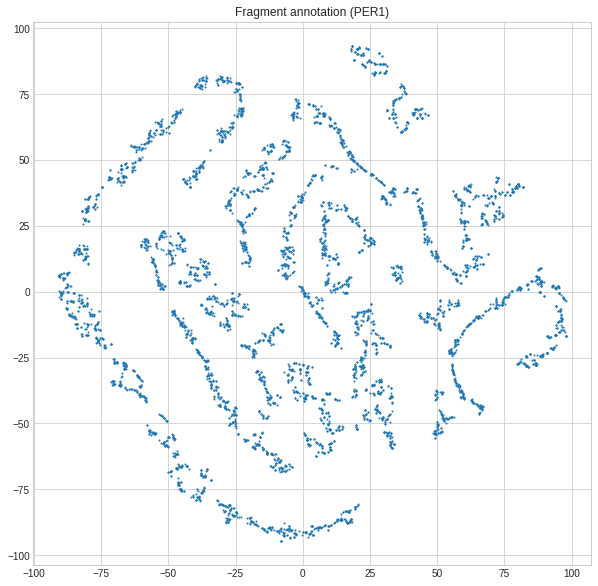

In [172]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,10))
img = ax.scatter(X_emb[:,0], X_emb[:,1], s=1)
plt.title("Fragment annotation (PER1)")
plt.show()

In [57]:
dat.loc[:,"Sample"]

0       Input1_20x
1       Input1_20x
2       Input1_20x
3       Input1_20x
4       Input1_20x
           ...    
6489      TFX5_Dex
6490      TFX5_Dex
6491      TFX5_Dex
6492      TFX5_Dex
6493      TFX5_Dex
Name: Sample, Length: 6494, dtype: object

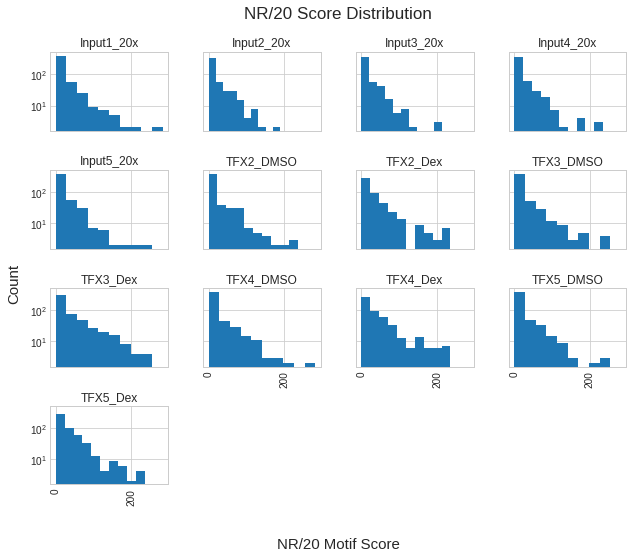

In [144]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,8))
axes = dat.loc[:,"NR/20"].hist(
    ax=ax,
    bins=10, 
    by=dat.loc[:,"Sample"], 
    #density=True, 
    sharex=True,
    sharey=True)

axes = np.ravel(axes)
for ax in axes:
    ax.set_yscale('log')
    
fig.suptitle("NR/20 Score Distribution", fontsize=17)
fig.text(0.5, 0.04, 'NR/20 Motif Score', ha='center', fontsize=15)
fig.text(0.04, 0.5, 'Count', va='center', rotation='vertical', fontsize=15)
plt.show()

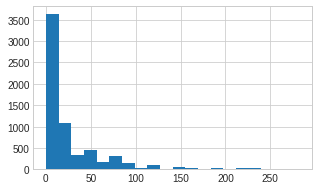

In [98]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,3))
dat.loc[:,"NR/20"].hist(ax=ax, bins=20)

Text(0.5, 1.0, 'NR/20')

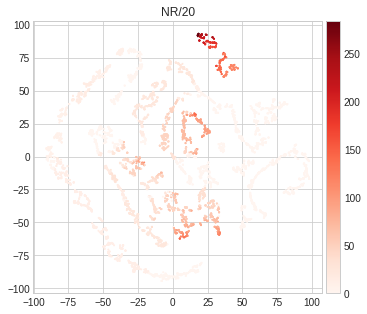

In [170]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5.5,5))
img = ax.scatter(X_emb[:,0], X_emb[:,1], s=1, c=dat.loc[:,"NR/20"], cmap="Reds")
set_colorbar(fig, ax, img)
ax.set_title("NR/20")

Text(0.5, 1.0, 'NR/20 x AP1/1')

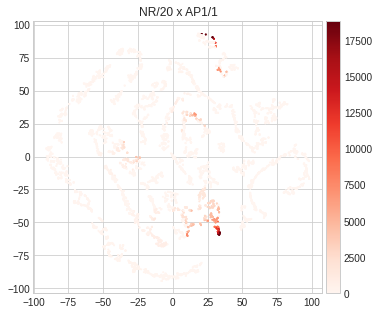

In [171]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5.5,5))
img = ax.scatter(X_emb[:,0], X_emb[:,1], s=1, c=dat.loc[:,"NR/20"]*dat.loc[:,"AP1/1"], cmap="Reds")
set_colorbar(fig, ax, img)
ax.set_title("NR/20 x AP1/1")

Text(0.5, 1.0, 'NR/20 x AP1/1')

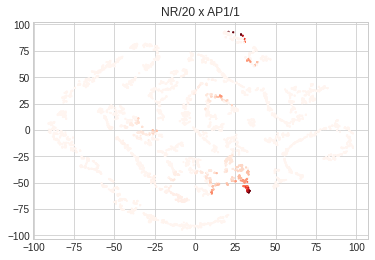

In [78]:
plt.scatter(X_emb[:,0], X_emb[:,1], s=1, c=dat.loc[:,"NR/20"]*dat.loc[:,"AP1/1"], cmap="Reds")
plt.title("NR/20 x AP1/1")

In [147]:
SAMPLES

array(['Input1_20x', 'Input2_20x', 'Input3_20x', 'Input4_20x',
       'Input5_20x', 'TFX2_DMSO', 'TFX3_DMSO', 'TFX4_DMSO', 'TFX5_DMSO',
       'TFX2_Dex', 'TFX3_Dex', 'TFX4_Dex', 'TFX5_Dex'], dtype='<U30')

{'Input1_20x': 'tab:green',
 'Input2_20x': 'tab:green',
 'Input3_20x': 'tab:green',
 'Input4_20x': 'tab:green',
 'Input5_20x': 'tab:green',
 'TFX2_DMSO': 'tab:blue',
 'TFX3_DMSO': 'tab:blue',
 'TFX4_DMSO': 'tab:blue',
 'TFX5_DMSO': 'tab:blue',
 'TFX2_Dex': 'tab:red',
 'TFX3_Dex': 'tab:red',
 'TFX4_Dex': 'tab:red',
 'TFX5_Dex': 'tab:red'}

In [162]:
from matplotlib.lines import Line2D

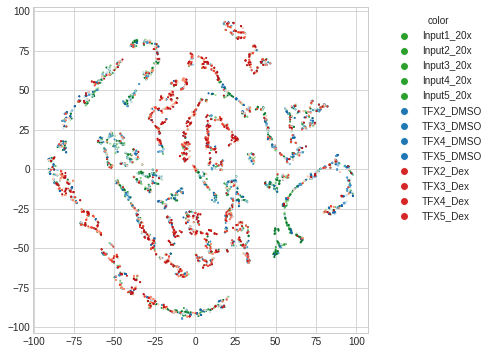

In [167]:
###
### Ref: stackoverflow: plot-different-color-for-different-categorical-levels-using-matplotlib 

### set color mapping
#colors = list(sns.color_palette("Greens", 5)) + list(sns.color_palette("Blues", 4)) + list(sns.color_palette("Reds", 4))
colors = ["tab:green"] * 5 + ["tab:blue"] * 4 + ["tab:red"] * 4
colors = {k:v for k, v in zip(SAMPLES, colors)}
colors

### scatter plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(X_emb[:,0], X_emb[:,1], s=1, c=dat.loc[:,"Sample"].map(cmap))


### add a legend
handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) 
    for k, v in colors.items()
]
ax.legend(title='color', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

In [61]:
tmp = dat
tmp = tmp.assign(x = X_emb[:,0], y = X_emb[:,1])
tmp.shape

(6494, 244)

In [62]:
import seaborn as sns

[(0.9882352941176471, 0.732072279892349, 0.6299269511726259),
 (0.9835755478662053, 0.4127950788158401, 0.28835063437139563),
 (0.7925720876585928, 0.09328719723183392, 0.11298731257208766)]

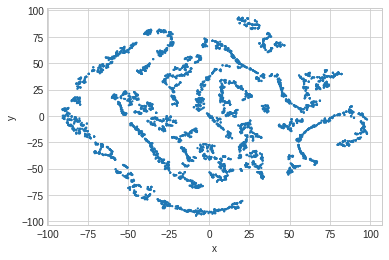

In [82]:
sns.scatterplot(x='x', y='y', data=tmp, s=5, ec=None)

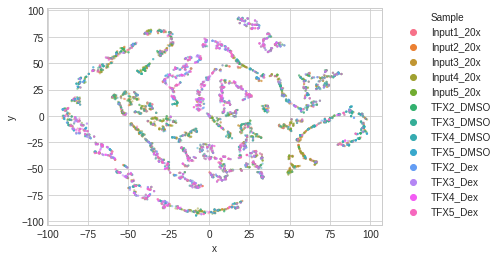

In [85]:
sns.scatterplot(x='x', y='y', data=tmp, s=5, ec=None, alpha=0.5, hue="Sample")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)